                                       EN2550 - Fundamentals of Image Processing and Machine Vision
                                                         Assignment 2

Index Number : 190280N                    
Name : Jegakumaran P.                
Github Link : 

In [110]:
#Question 1
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
from skimage.measure import CircleModel, ransac
# np.random.seed(0)
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0,2*np.pi,half_n)
n = s*np.random.randn(half_n)
x , y = (r+n)*np.cos(t),(r+n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1)))
m, b = -1,2
x = np.linspace(-12,12,half_n)
y = m*x+b+s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1)))
X = np.vstack((X_circ,X_line))

In [111]:
# RANSAC Function
class RANSAC:
	def __init__(self, x_data, y_data, n):
		self.x_data = x_data
		self.y_data = y_data
		self.n = n # n: how many times try sampling
		self.d_min = 99999
		self.best_model = None

	def random_sampling(self):
		sample = []
		save_ran = []
		count = 0

		# get three points from data
		while True:
			ran = np.random.randint(len(self.x_data))

			if ran not in save_ran:
				sample.append((self.x_data[ran], self.y_data[ran]))
				save_ran.append(ran)
				count += 1

				if count == 3:
					break

		return sample

	def make_model(self, sample):
		# calculate A, B, C value from three points by using matrix
	
		pt1 = sample[0]
		pt2 = sample[1]
		pt3 = sample[2]

		A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]]) 
		B = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])		
		inv_A = np.linalg.inv(A) 

		c_x, c_y = np.dot(inv_A, B) / 2
		c_x, c_y = c_x[0], c_y[0]
		r = np.sqrt((c_x - pt1[0])**2 + (c_y - pt1[1])**2)

		return c_x, c_y, r

	def eval_model(self, model):
		d = 0
		c_x, c_y, r = model

		for i in range(len(self.x_data)):
			dis = np.sqrt((self.x_data[i]-c_x)**2 + (self.y_data[i]-c_y)**2)

			if dis >= r:
				d += dis - r
			else:
				d += r - dis
		
		return d

	def execute_ransac(self):
		# find best model
		for i in range(self.n):
			sample=self.random_sampling()
			model = self.make_model(sample)
			d_temp = self.eval_model(model)
			
			if self.d_min > d_temp:
				self.best_model = model
				self.d_min = d_temp
				best_sample=sample
		return best_sample




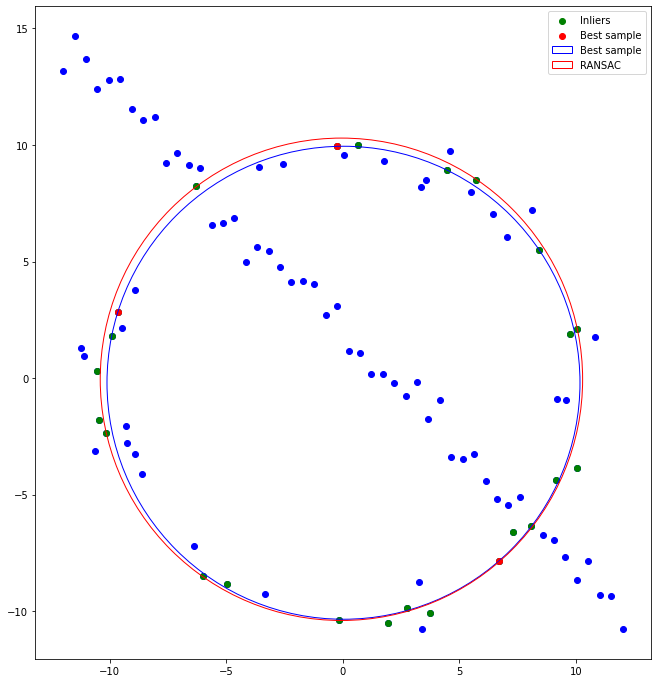

In [112]:
size=len(X[:,0])
ransac = RANSAC(X[:,0],X[:,1], 50)
	
# execute ransac algorithm
sample = ransac.execute_ransac()
	
# get best model from ransac
a, b, r = ransac.best_model[0], ransac.best_model[1], ransac.best_model[2]

threshold=0.5
inliers=[]
for i in range(size):
	if np.sqrt((X[i,0]-a)**2+(X[i,1]-b)**2)<r+threshold and np.sqrt((X[i,0]-a)**2+(X[i,1]-b)**2)>r-threshold:
		inliers.append(np.array(X[i]))
inliers=np.array(inliers)

# show result
plt.figure(figsize=(12,12))
plt.scatter(X[:,0],X[:,1],c='blue', marker='o')
plt.scatter(inliers[:,0],inliers[:,1],c='g',marker='o',label='Inliers')

ransac = RANSAC(inliers[:,0],inliers[:,1], 50)
sample2 = ransac.execute_ransac()
for i in range(len(sample2)):
	sample2[i]=np.array(sample2[i])
sample2=np.array(sample2)
plt.scatter(sample2[:,0],sample2[:,1],c='r',marker='o',label='Best sample')
# get best model from ransac
a_best, b_best, r_best = ransac.best_model[0], ransac.best_model[1], ransac.best_model[2]
circle = plt.Circle((a_best, b_best), radius=r_best, color='b', fc='y', fill=False,label='Best sample')
plt.gca().add_patch(circle)

circle = plt.Circle((a, b), radius=r, color='r', fc='y', fill=False,label='RANSAC')
plt.gca().add_patch(circle)
plt.axis('scaled')
plt.legend()
plt.show()

In [22]:
# Question 2
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal

def getImageCorners(image):
    corners = np.zeros((4, 1, 2), dtype=np.float32)
    (width, length, values) = image.shape
    corners[0] = (0, 0)
    corners[1] = (0, width)
    corners[2] = (length, 0)
    corners[3] = (length, width)
    return corners
def findMatchesBetweenImages(image_1, image_2, num_matches):
    # matches - type: list of cv2.DMath
    matches = None
    # image_1_kp - type: list of cv2.KeyPoint items.
    image_1_kp = None
    # image_1_desc - type: numpy.ndarray of numpy.uint8 values.
    image_1_desc = None
    # image_2_kp - type: list of cv2.KeyPoint items.
    image_2_kp = None
    # image_2_desc - type: numpy.ndarray of numpy.uint8 values.
    image_2_desc = None

    sift = cv.SIFT_create()
    #Compute keypoints and descriptors
    image_1_kp, image_1_desc = sift.detectAndCompute(image_1, None)
    image_2_kp, image_2_desc = sift.detectAndCompute(image_2, None)

    bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
    #Compute matches
    matches = bf.match(image_1_desc, image_2_desc)
    #Sort
    matches = sorted(matches, key = lambda x:x.distance)
    #Get 10 matches
    matches = matches[:num_matches]

    return image_1_kp, image_2_kp, matches
def findHomography(image_1_kp, image_2_kp, matches):
    image_1_points = np.zeros((len(matches), 1, 2), dtype=np.float32)
    image_2_points = np.zeros((len(matches), 1, 2), dtype=np.float32)
    for i in range(len(matches)):
        image_1_points[i] = image_1_kp[matches[i].queryIdx].pt
        image_2_points[i] = image_2_kp[matches[i].trainIdx].pt

    homography, mask = cv.findHomography(image_1_points, image_2_points, cv.RANSAC, 5.0)
    return homography

def blendImagePair(warped_image, image_2, point):
    output_image = np.copy(warped_image)
    blendpart = output_image[np.uint8(point[1]):,np.uint8(point[0]):]
    blendpart = blendpart[:image_2.shape[0]+1, :image_2.shape[1]+1]
    blendedimage = image_2
    print(np.shape(blendpart))
    for x in range(image_2.shape[0]):
        for y in range(image_2.shape[1]):
            if blendpart[x][y].any() != 0:
                blendedimage[x][y] = np.mean(np.array([blendpart[x][y], image_2[x][y]]), axis = 0)

    output_image[np.uint8(point[1]):np.uint8(point[1]) + image_2.shape[0],np.uint8(point[0]):np.uint8(point[0]) + image_2.shape[1]] = blendedimage

    return output_image

def warpImagePair(image_1, image_2, homography):
    # Store the result of cv2.warpPerspective in this variable.
    warped_image = None
    # The minimum and maximum values of your corners.
    x_min = 0
    y_min = 0
    x_max = 0
    y_max = 0

    #get image corners
    image_1_corners = getImageCorners(image_1)
    image_2_corners = getImageCorners(image_2)

    #Transform the perspective image 1 corners
    image_1_corners = cv.perspectiveTransform(image_1_corners, homography)

    #Join Corners into (8,1,2)
    joined = np.concatenate((image_1_corners, image_2_corners))

    #Find min/max values for X and Y values
    left = joined[:, :, :1]
    right = joined[:, :, 1:]
    x_min = np.min(left)
    x_max = np.max(left)
    y_min = np.min(right)
    y_max = np.max(right)

    #Translation matrix
    translation = np.array([[1, 0, -1 * x_min], [0, 1, -1 * y_min], [0, 0, 1]])

    #Dot product of translation matrix and homography
    dotProduct = np.dot(translation, homography)

    #Warp Perspective
    vector = (np.uint8(x_max - x_min), np.uint8(y_max - y_min))
    warped_image = cv.warpPerspective(image_1, dotProduct,vector)
    output_image = blendImagePair(warped_image, image_2,(-1 * x_min, -1 * y_min))
    return output_image


image_1 = cv.imread("Images/images/001.jpg",cv.IMREAD_ANYCOLOR)
image_2 = cv.imread("Images/Flag_of_the_United_Kingdom.svg.png",cv.IMREAD_ANYCOLOR)
image_1_kp, image_2_kp, matches = findMatchesBetweenImages(image_1, image_2,20)                                                          
homography = findHomography(image_1_kp, image_2_kp, matches)
result = warpImagePair(image_1, image_2, homography)
plt.figure()
plt.imshow(cv.cvtColor(result,cv.COLOR_BGR2RGB))
plt.show()

(192, 127, 3)


IndexError: index 127 is out of bounds for axis 0 with size 127

In [ ]:
import numpy as np
import cv2 as cv
import scipy as sp
import scipy.signal

def findHomography(image_1_kp, image_2_kp, matches):
    image_1_points = np.zeros((len(matches), 1, 2), dtype=np.float32)
    image_2_points = np.zeros((len(matches), 1, 2), dtype=np.float32)

    for i in range(0,len(matches)):
        image_1_points[i] = image_1_kp[matches[i].queryIdx].pt
        image_2_points[i] = image_2_kp[matches[i].trainIdx].pt


    homography, mask = cv.findHomography(image_1_points, image_2_points, cv.RANSAC, ransacReprojThreshold=2.0)

    return homography

img1 = cv.imread(r"Images/images/001.jpg",cv.IMREAD_ANYCOLOR)
img2 = cv.imread(r"Images/Flag_of_the_United_Kingdom.svg.png",cv.IMREAD_ANYCOLOR)

img1_gray = cv.cvtColor(img1, cv.IMREAD_GRAYSCALE)
img2_gray = cv.cvtColor(img2, cv.IMREAD_GRAYSCALE)

#sift
sift = cv.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1_gray,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2_gray,None)

#feature matching
bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)
H = findHomography(img1,img2,matches)
im1to2=cv.warpPerspective(img1,np.linalg.inv(H),(2000,2000))
plt.figure(figsize=(15,8))
plt.imshow(cv.cvtColor(im1to2,cv.COLOR_BGR2RGB)),plt.show()